In [19]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import os

In [22]:

def load_activations(model_type, layers, activation_types):
    activations = {at_type: {} for at_type in activation_types}
    
    for at_type in activation_types:
        base_path = f'../data_store/{model_type}/{at_type}'
        
        for layer in layers:
            harmless_path = os.path.join(base_path, f'harmless_layer{layer}.pt')
            harmful_path = os.path.join(base_path, f'harmful_layer{layer}.pt')
            intervention_path = os.path.join(base_path, f'intervention_layer{layer}.pt')
            
            activations[at_type][layer] = {
                'harmless': torch.load(harmless_path),
                'harmful': torch.load(harmful_path),
                'intervention': torch.load(intervention_path)
            }
    
    return activations

def plot_activations_pca(activations, layers, activation_types, refusal_rate):
    n_layers = len(layers)
    n_types = len(activation_types)
    
    fig, axs = plt.subplots(n_layers, n_types, figsize=(6*n_types, 5*n_layers + 1))
    if n_layers == 1 and n_types == 1:
        axs = np.array([[axs]])
    elif n_layers == 1 or n_types == 1:
        axs = axs.reshape(n_layers, n_types)

    for layer_idx, layer in enumerate(layers):
        for type_idx, at_type in enumerate(activation_types):
            layer_activations = activations[at_type][layer]
            
            # combine activations & apply PCA
            all_activations = torch.cat([
                layer_activations['harmless'], 
                layer_activations['harmful'], 
                layer_activations['intervention']
            ], dim=0)
            
            pca = PCA(n_components=2)
            projected_activations = pca.fit_transform(all_activations.cpu().numpy())

            n = len(layer_activations['harmful'])
            harmless_proj = projected_activations[:n]
            harmful_proj = projected_activations[n:2*n]
            intervention_proj = projected_activations[2*n:]

            # plot on the corresponding subplot
            ax = axs[layer_idx, type_idx]
            ax.scatter(harmless_proj[:, 0], harmless_proj[:, 1], color='green', label='Harmless', alpha=0.6)
            ax.scatter(harmful_proj[:, 0], harmful_proj[:, 1], color='red', label='Harmful', alpha=0.6)
            ax.scatter(intervention_proj[:, 0], intervention_proj[:, 1], color='blue', label='Intervention', alpha=0.6)

            ax.legend()
            ax.set_title(f"Layer {layer} - {at_type.upper()}")
            ax.set_xlabel("PC 1")
            ax.set_ylabel("PC 2")

    # Refusal Rate: {refusal_rate} -- not included
    
    fig.subplots_adjust(top=0.95)  # Adjust this value to move the title up or down
    fig.suptitle(f"Refusal Direction PCA\nModel: ablated_llama-2-7b\n", fontsize=16)

    plt.tight_layout()
    plt.savefig(f"refusal_direction_pca_multi_layer_multi_type.png")
    plt.show()
    plt.close()

/tmp/ipykernel_9033/3167644612.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  'harmless': torch.load(harmless_path),
/tmp/ipykernel_9033/3167644612.py:14: FutureWarnin

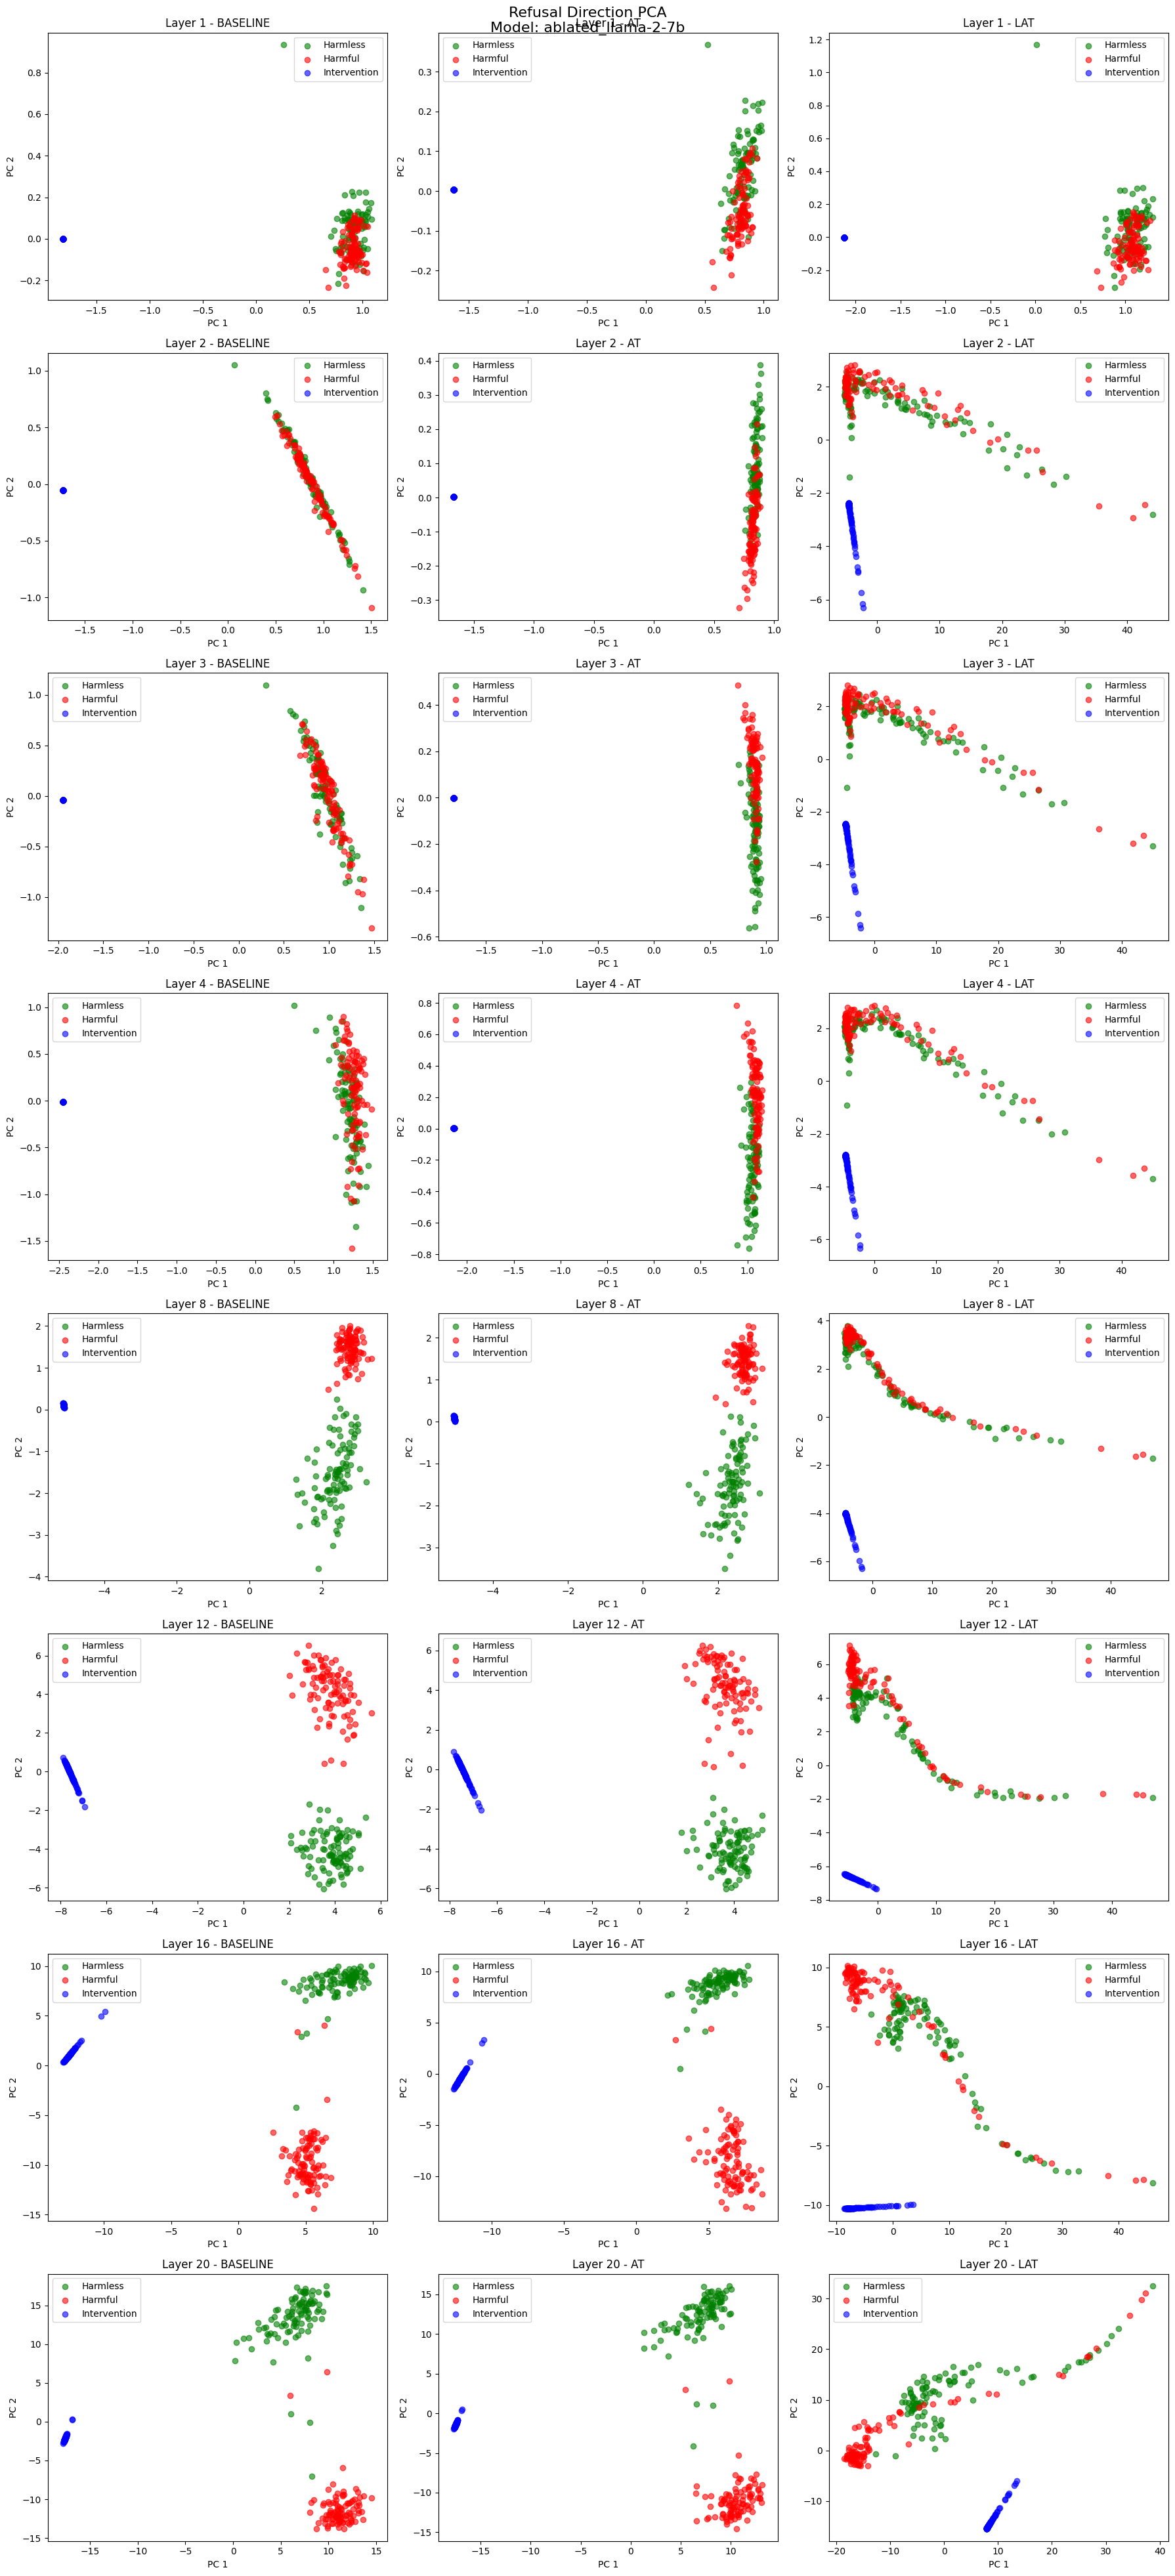

In [24]:
layers_to_analyze = [1, 2, 3, 4, 8, 12, 16, 20] # options 1, 2, 3, 4, 8, 12, 16, 20
tuning = ['baseline','at','lat']  # options baseline, at, lat, 
refusal_rate = "10.00%"
model_type = 'ablated_llama-2-7b'

activations = load_activations(model_type, layers_to_analyze, tuning)
plot_activations_pca(activations, layers_to_analyze, tuning, refusal_rate)